In [1]:
import matplotlib.pyplot as plt
plt.style.use(['classic'])
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from astropy.io import fits
from scipy import stats
from scipy.stats import binned_statistic
from scipy.linalg import block_diag,eigh
plt.rcParams['font.family']='stixgeneral'
plt.rcParams.update({'font.size':16})
from astropy.io import fits
import ebf
import pdb
from mpl_toolkits.mplot3d import Axes3D
from astropy.coordinates import (CartesianRepresentation,CartesianDifferential)
from astropy.coordinates import Galactic

from astropy.coordinates import SkyCoord

/Users/Jenny/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/Jenny/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/Jenny/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import csv
import pandas
from astropy.table import Table, Column, MaskedColumn
from astropy import units as u


In [24]:
#read in the data from Xue 2208 et al. (~2500 BHB stars)
t = Table.read("BHB2500.txt", format="ascii.cds")

In [25]:
print (t)

    SpName               Name            RAdeg    ...  log(g)  FeH  Type
                                          deg     ... [cm.s2]  [-]      
-------------- ----------------------- ---------- ... ------- ----- ----
51602-0266-125 SDSSJ094317.57-011021.2 145.823196 ...    3.12 -2.03  BHB
51602-0266-397 SDSSJ094138.17+001821.5 145.409058 ...    3.81 -1.97  BHB
51602-0266-634 SDSSJ094840.23+002818.0 147.167633 ...     4.2 -1.27  BHB
51609-0292-102 SDSSJ125223.54-003708.2 193.098083 ...    2.61 -1.96  BHB
51609-0292-329 SDSSJ124641.66+003751.2 191.673569 ...    2.95  -2.0  BHB
51609-0292-351 SDSSJ124449.35+002157.4 191.205612 ...    3.11 -1.43  BHB
51609-0292-582 SDSSJ125254.01+002903.2 193.225037 ...    3.14 -1.66  BHB
51609-0304-219 SDSSJ141723.88-002220.8 214.349503 ...   -9.99 -9.99  BHB
51613-0305-243 SDSSJ142408.24-002930.7 216.034348 ...    3.68 -2.26  BHB
51613-0305-488 SDSSJ142826.28+002915.4 217.109497 ...    2.87 -2.95  BHB
           ...                     ...        ... .

In [134]:
zmin = 20
zmax = 60
zlim = 4.

In [44]:
# cutting r and z > 20 & r < 60 kpc stars 
df1=pd.DataFrame()
df2=pd.DataFrame()
df1['x']=t['x'][ (zmin < t['r'] ) & (t['r'] < zmax ) ]
df1['y']=t['y'][ (zmin < t['r'] ) & (t['r'] < zmax ) ]
df1['z']=t['z'][ (zmin < t['r'] ) & (t['r'] < zmax ) ]
df1['Vgal']= t['RVgal'][ (zmin < t['r'] ) & (t['r'] < zmax ) ]
df1['r']= t['r'][ (zmin < t['r'] ) & (t['r'] < zmax )]
df2['r']=df1['r'][(np.absolute(df1['z']) > zlim)]
df2['x']=df1['x'][(np.absolute(df1['z']) > zlim)]
df2['y']=df1['y'][(np.absolute(df1['z']) > zlim) ]
df2['z']=df1['z'][(np.absolute(df1['z']) > zlim)]
df2['Vgal']= df1['Vgal'][(np.absolute(df1['z']) > zlim)]

In [153]:
#data for verifying Xue 2008 et al paper 
df3 = pd.DataFrame()
df3['x']=t['x'][ (np.absolute(t['z']) > zlim) ]
df3['y']=t['y'][ (np.absolute(t['z']) > zlim) ]
df3['z']=t['z'][ (np.absolute(t['z']) > zlim) ]
df3['Vgal']= t['RVgal'][ (np.absolute(t['z']) > zlim) ]
df3['r']= t['r'][(np.absolute(t['z']) > zlim)]

In [154]:
len(df3['r'])

2424

In [155]:
#class for the input of the correlation function 
class Comp:
    def __init__(self,x,y,z,rv):
        '''
        class for the input of the correlation function 
        :param x: x position for the target 
        :param y: y position for the target 
        :param z: z position for the target
        :param rv: radial velocity for the target 
        
        '''

        self.x = np.array(x)
        self.y = np.array(y)
        self.z = np.array(z)
        self.rv = np.array(rv)



In [138]:
k= Comp(df3['x'],df3['y'],df3['z'],df3['Vgal'])

In [139]:
# calculating the correlation function 
def correlated_function(data,w):
    '''
        Function for  calculating the correlation function 
        :param data: data for calculating the correlation function (x,y,z, radial velocity)
        :param w: parameter w in the equation of the correlation function 
        :return: phase-space separation (delta)^2
        
    '''

    dia=[]
    vdiff = []
    spacedt = []
    for ii in range(0,len(data.rv)): 
        
        
    
        vi = np.repeat(data.rv[ii],len(data.rv))
        xi = np.repeat(data.x[ii],len(data.rv))
        yi = np.repeat(data.y[ii],len(data.rv))
        zi = np.repeat(data.z[ii],len(data.rv))
        
        diffv = w**2*(vi - data.rv)**2
        diffx = (xi - data.x)**2
        diffy = (yi - data.y)**2
        diffz = (zi - data.z)**2
        
        
        
        
        diff = diffv+diffx+diffy+diffz
        spaced = diffx+diffy+diffz
        #print (diffv, diffx, diffy, diffz,diff)
            
            
        dia.append(diff)
        vdiff.append(np.absolute(vi - data.rv))
        spacedt.append(np.sqrt(spaced))
        
        
    diaf = np.array(dia)[np.triu_indices(len(diff),1)]
    vdiffto = np.array(vdiff)[np.triu_indices(len(diff),1)]
    specdto = np.array(spacedt)[np.triu_indices(len(diff),1)]
    return diaf,vdiffto,specdto
    
    
        
        
    
    

In [140]:
c = SkyCoord(x=df2['x'], y=df2['y'], z=df2['z'], unit='kpc',representation_type='cartesian')

In [141]:
testcor,testvd,testspaced = correlated_function(k,1)

In [142]:
logspc = np.log10(testspaced)

In [144]:
sortspc = sorted(logspc)
sort_index = np.argsort(logspc)
sortv = testvd[sort_index]

In [145]:
sortvf = np.array(sortv)[(np.array(sortspc) > 0)& (np.array(sortspc) < 2.05)]
sortspcf = np.array(sortspc)[(np.array(sortspc) > 0)& (np.array(sortspc) < 2.05)]

In [146]:
from scipy import stats

In [147]:
binspc = stats.binned_statistic(sortspcf,sortspcf, 'mean', bins=18)
binv = stats.binned_statistic(sortspcf, sortvf , 'mean', bins=18)

In [148]:
binspc[1][:-1]

array([9.64327467e-17, 1.13888732e-01, 2.27777463e-01, 3.41666195e-01,
       4.55554926e-01, 5.69443658e-01, 6.83332390e-01, 7.97221121e-01,
       9.11109853e-01, 1.02499858e+00, 1.13888732e+00, 1.25277605e+00,
       1.36666478e+00, 1.48055351e+00, 1.59444224e+00, 1.70833097e+00,
       1.82221971e+00, 1.93610844e+00])

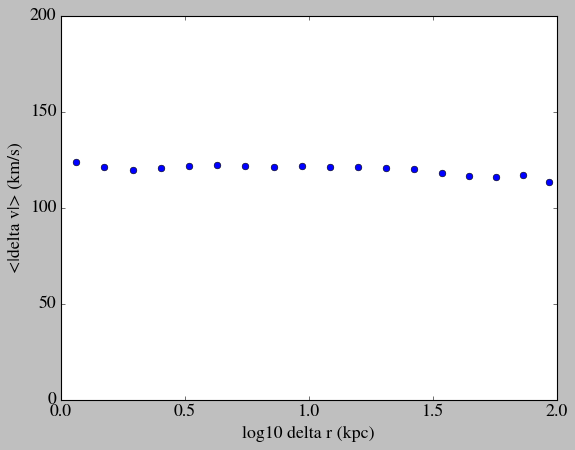

In [152]:
#final plot for verifying Xue's data
plt.plot(binspc[0],binv[0],'o')
plt.ylim(0,200)
plt.ylabel('<|delta v|> (km/s)')
plt.xlabel('log10 delta r (kpc)')
plt.show()

In [13]:
lb_random = Comp(df2['r'],c.galactic.l/u.degree,c.galactic.b/u.degree,df2['Vgal'])